In [3]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
import os
import sys
import datetime
sys.path.append(os.path.dirname(os.getcwd()))
from corpus_creation import *
from corpus_creation_utils import *

In [2]:
wikipedia.set_lang("en")  #We make our research in english

## Section 1 - create corpus (see section 3 to load existing file instead)

In [ ]:
SEARCH_TERM = "circadian clock"
SECONDARY_TERM = None
SECONDARY_TERM = SECONDARY_TERM or SEARCH_TERM

In [ ]:
%%time
search_list = corpus_selection(SEARCH_TERM,5000, SECONDARY_TERM)


In [ ]:
print(len(search_list),search_list)

### Get the information on the protected articles of the corpus

In [ ]:
protection_status_evolution = get_protection_status(search_list)

### Creation of the dataframe

In [ ]:
df=crea_dataframe(search_list, SEARCH_TERM)
df.head()

### Get the citations

In [ ]:
df = parse_df_citations(df)
logger.info(f'mean scietificness score {df["nbjournaldetected"].sum()/df["nb_journal_citations"].sum()}')


In [ ]:

urls = get_modified_urls(df["Name only"]) #make a list will all titles
df = add_pageinfo(df, urls)
df = clean_df(df)


## 2. Save csv file

In [ ]:
fileName = 'wikiscore_' + SEARCH_TERM + '_' + str(datetime.datetime.now())[:10]
df.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'outputs', fileName + '.csv'))


## 3. load existing file instead

In [4]:
load_existing=True
if load_existing:
    df=pd.read_csv('/home/ro/Documents/code/wiki-score/outputs/wikiscore_crispr_2022-06-27.csv')

## 4. Plot some stats

### to-do: remove duplicate plot functions definitions. 

In [5]:
def plot_site_most_cited(d,top : int, title : str):
    '''
    plot the most cited sites
    
    param d: a column of a dataframe containing the text of the type of citation for example .org or only scientific journal
    param minimum: the minimum number of times an site is cited to appear in our plot
    '''
    
    sns.set_style("white")
    d=d[0:top]
    palette ={"org" : "#8da0cb",
             "com" : "#fc8d62" ,
             "IPCC" : "#a6d854",
             "gov" : "#e78ac3",
             "journal" : "#66c2a5"}
    
    ax=sns.barplot(x="number of times cited", y="name of site", hue="type", palette=palette, data=d,dodge=False,orient = 'h')
    #sns.despine(left=True, bottom=True)
    sns.move_legend(ax,"lower right")
    for i in ax.containers:
        ax.bar_label(i,)
    #sns.set(font_scale=3)
    plt.legend(loc = 2, bbox_to_anchor = (1,0.5))
    ax.set(xlabel='Number of references',ylabel='',title=title)
    #sns.set_context("paper")
    sns.set_context("poster")
    sns.set(rc={"figure.figsize":(12, 11)}) #width=3, #height=4
    sfig = ax.get_figure()
    sfig.savefig('most cited journal.svg')
    #plt.savefig('most cited journal.png')

In [6]:
dftot,dico=sortcitation(df.loc[:,"citationtext_total"],df)
plot_site_most_cited(dftot,0)

ValueError: Wrong number of items passed 37, placement implies 1

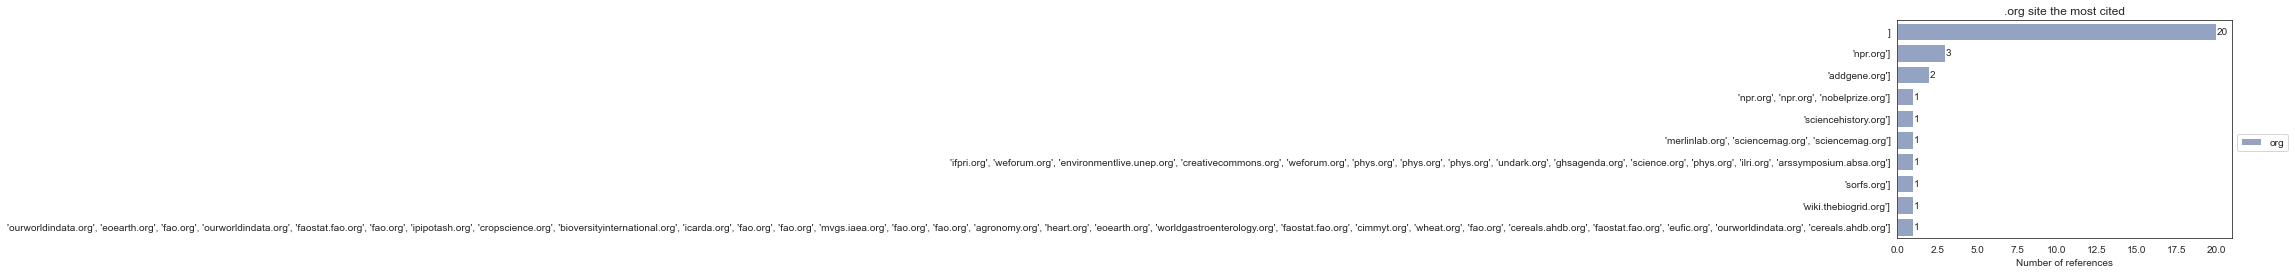

In [7]:
#An example of the plot for .org citation
dorg,dico=sortcitation(df.loc[:,"citationorgtext"],"org")    
plot_site_most_cited(dorg,10,".org site the most cited")

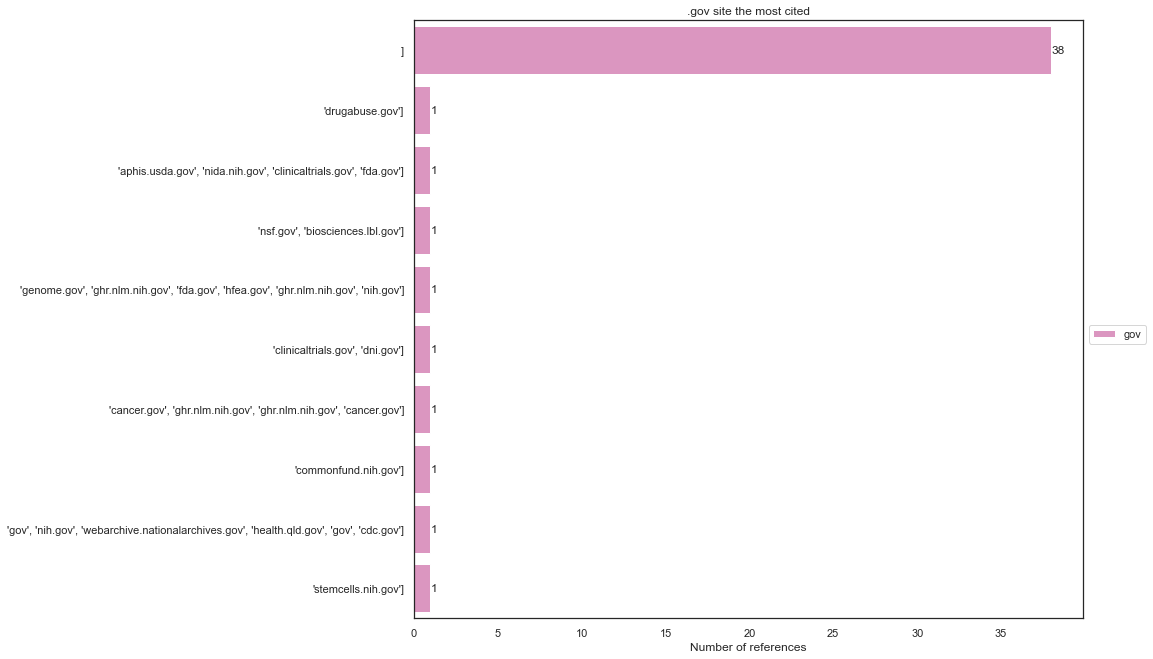

In [8]:
dfgov,j=sortcitation(df.loc[:,"citationgovtext"],"gov")
plot_site_most_cited(dfgov,10,".gov site the most cited")

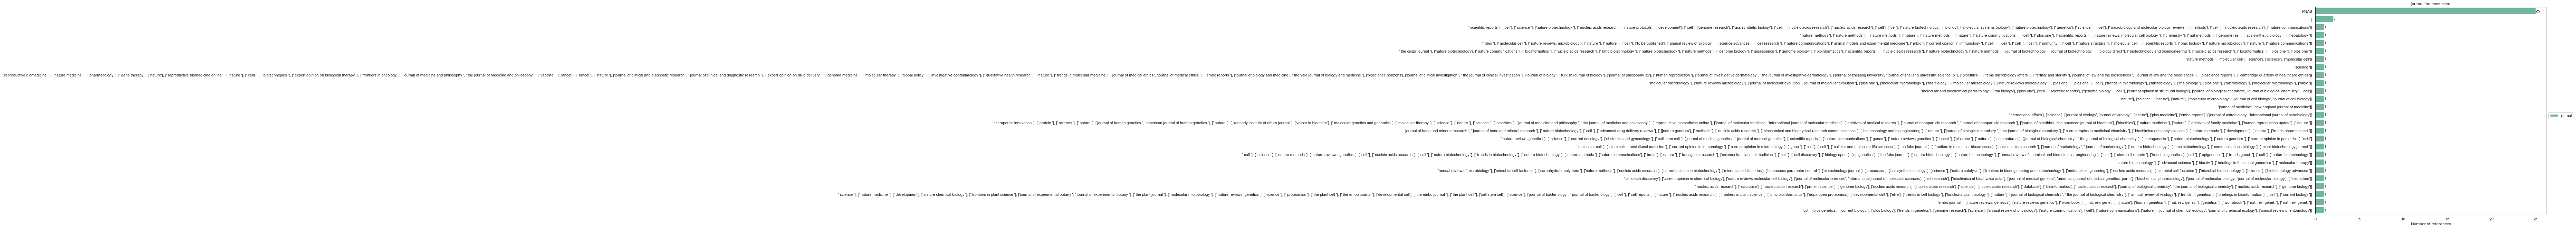

In [9]:
dfsci,j=sortcitation(df.loc[:,"journal"],"journal")
dfsci.loc[dfsci["name of site"]=="bioscience","number of times cited"]+=2
dfsci.sort_values(by=['number of times cited'], inplace=True, ascending=False)
plot_site_most_cited(dfsci,30, "journal the most cited")

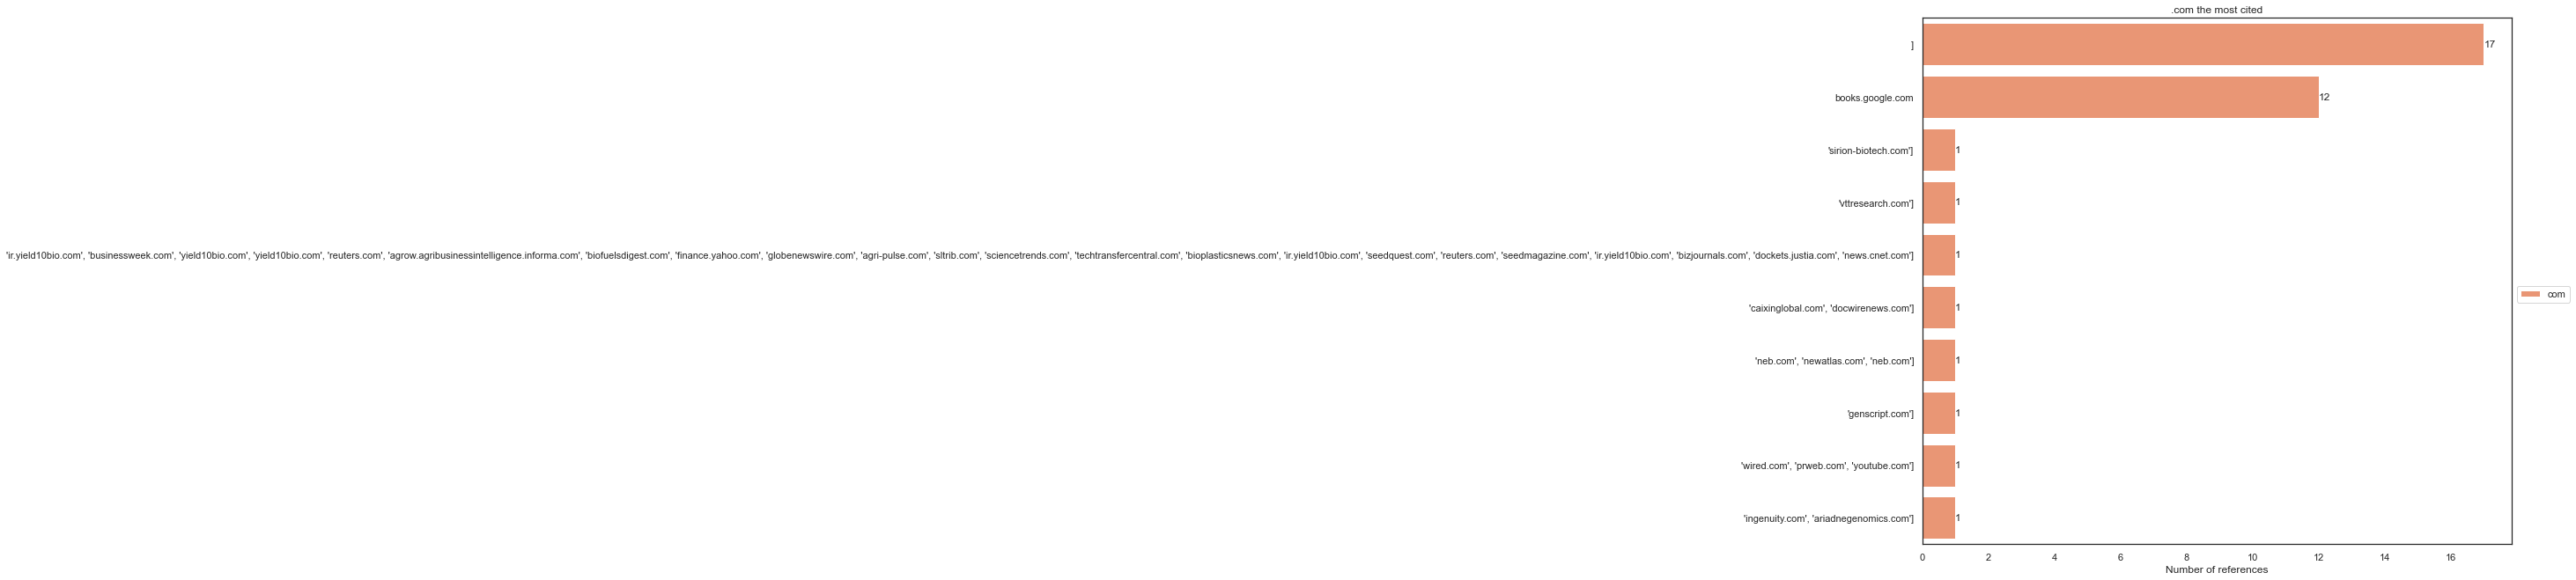

In [10]:
dcom,bl=sortcitation(df.loc[:,"citationcomtext"],"com")
plot_site_most_cited(dcom,10, ".com the most cited")

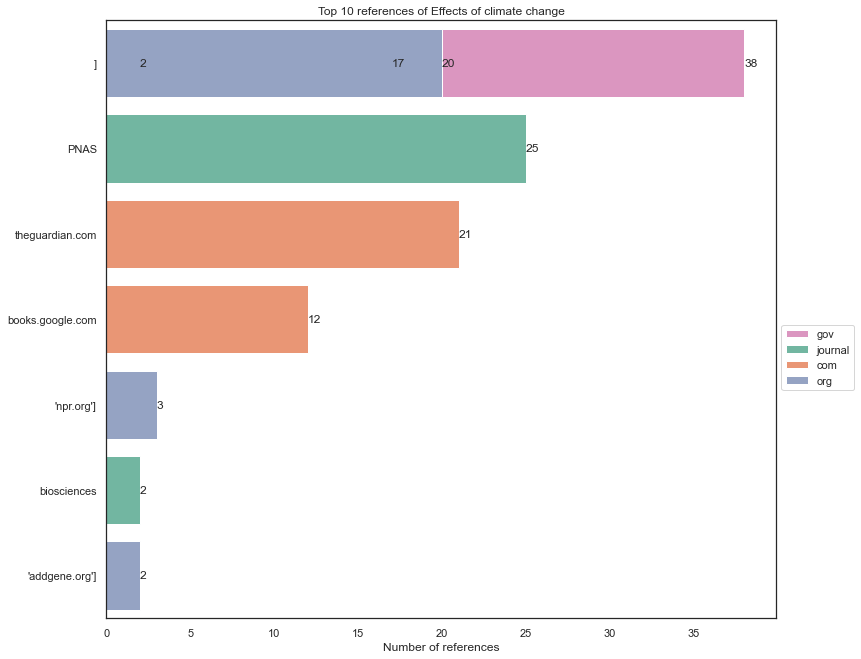

In [11]:
dIg={"name of site": ["IPCC","theguardian.com","biosciences"], "number of times cited":[df.loc[:,"citation IPCC"].sum(), df.loc[:,"citationguardian"].sum(),2], "type": ["IPCC","com","journal"]}
dIg = pd.DataFrame.from_dict(dIg)
big_df = pd.concat([dorg, dfgov,dcom,dfsci,dIg], ignore_index=True)
big_df.sort_values(by=['number of times cited'], inplace=True, ascending=False)
plot_site_most_cited(big_df,10,"Top 10 references of Effects of climate change")

#### plot of the timeline

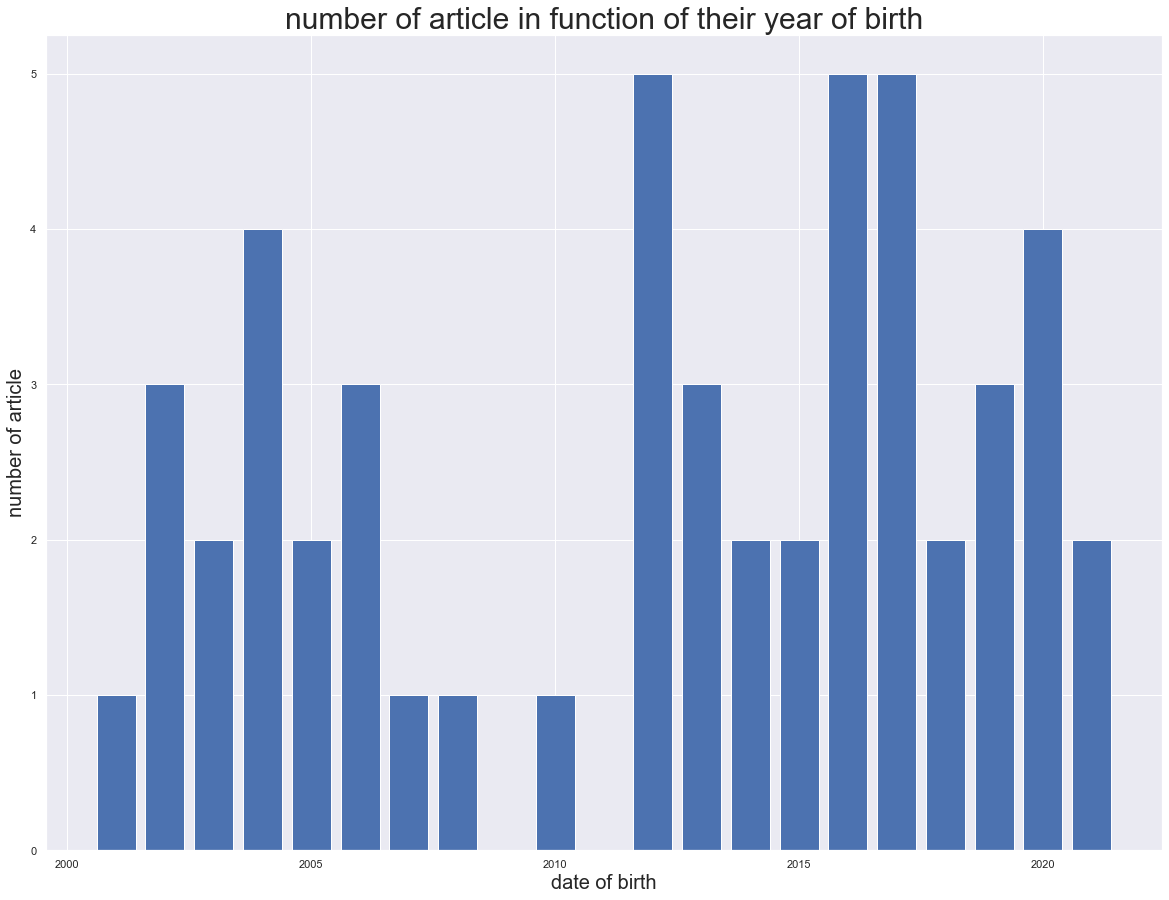

In [21]:
fig = plt.figure(0,figsize=(20,15))
plothist=plt.bar(df["Year"].value_counts().sort_index().index,df["Year"].value_counts().sort_index().values)
fig.savefig('timeline.jpg', bbox_inches='tight', dpi=150)
plt.xlabel('date of birth',fontsize = 20) 
plt.ylabel('number of article',fontsize = 20) 
plt.title("number of article in function of their year of birth",fontsize = 30)
plt.show()

In [17]:
df["Year"]

0     2005
1     2019
2     2021
3     2010
4     2017
5     2019
6     2020
7     2015
8     2020
9     2017
10    2013
11    2012
12    2005
13    2012
14    2017
15    2006
16    2019
17    2015
18    2016
19    2003
20    2017
21    2017
22    2004
23    2018
24    2004
25    2014
26    2004
27    2016
28    2002
29    2007
30    2001
31    2014
32    2004
33    2012
34    2020
35    2012
36    2008
37    2013
38    2016
39    2003
40    2002
41    2006
42    2006
43    2016
44    2016
45    2018
46    2020
47    2021
48    2002
49    2012
50    2013
Name: Year, dtype: int64